# Fibre Neural Network

In [7]:
# Imports
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import matplotlib.ticker as ticker
import random
import os
from functools import singledispatch
from typing import Union

import torch
import torch.nn as nn
from torch.nn import Parameter

# Importing Data - From USB
if os.path.exists("F:/venv code/Y3 Work/Fibres/MATLAB Files"):
    PIM_data = sc.io.loadmat("F:/venv code/Y3 Work/Fibres/MATLAB Files/Modes.mat")
    modes = PIM_data["F2"].transpose(2,0,1) # Modes
    PIMs_torch = torch.tensor(modes, dtype=torch.cfloat)

    beta_data = sc.io.loadmat("F:/venv code/Y3 Work/Fibres/MATLAB Files/Beta.mat")
    beta = beta_data["Beta"] # Phase velocities for each mode
    beta_torch = torch.tensor(beta, dtype=torch.cfloat)

    print("Files imported from USB.")

# Importing Data - From Kaggle
elif os.path.exists("/kaggle/input/fibre-data"):
    PIM_data = sc.io.loadmat("/kaggle/input/fibre-data/Modes.mat")
    modes = PIM_data["F2"].transpose(2,0,1) # Modes
    PIMs_torch = torch.tensor(modes, dtype=torch.cfloat)

    beta_data = sc.io.loadmat("/kaggle/input/fibre-data/Beta.mat")
    beta = beta_data["Beta"] # Phase velocities for each mode
    beta_torch = torch.tensor(beta, dtype=torch.cfloat)

    print("Files imported from Kaggle database.")

else:
    print("No files found.")

# Check if GPU is registered and being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

if torch.cuda.is_available():
    devNumber = torch.cuda.current_device()
    print(f"The current device number is {devNumber}")

    dev_name = torch.cuda.get_device_name(devNumber)
    print(f"GPU is {dev_name}")
else:
    print(f"No GPU available.")

Files imported from Kaggle database.
Using Device: cuda
The current device number is 0
GPU is Tesla P100-PCIE-16GB


In [53]:
# Functions

# Make a vectorising function
def vectorise(field):
    x = field.shape[0]
    y = field.shape[1]
    return field.reshape(x*y,1)

# Make an unvectorising function
def unvectorise(field, dim):
    return field.reshape(dim,dim)

def Complex2HSV(z, rmin, rmax, hue_start=90):
    # get amplidude of z and limit to [rmin, rmax]
    amp = np.abs(z)
    amp = np.where(amp < rmin, rmin, amp)
    amp = np.where(amp > rmax, rmax, amp)
    ph = np.angle(z, deg=1)# + hue_start
    # HSV are values in range [0,1]
    h = (ph % 360) / 360
    s = 0.85 * np.ones_like(h)
    v = (amp -rmin) / (rmax - rmin)
    return hsv_to_rgb(np.dstack((h,s,v)))

def beta_matrix(length=0):
    """New function to make the diagonal square matrix for PIM propagation in an MMF. Takes inputs from the CPU and will return a tensor on the GPU."""
    beta_data = beta_torch.cpu() # Needs imported data
    betas = []
    for i in range(len(beta_data)):
        beta = beta_data[i].item().real
        angle = length * beta
        z = np.exp(1j * angle)
        betas.append(z)
    
    # Convert the list to an np.array()
    betas = np.asarray(betas, dtype=np.complex64)
    # Convert the np.array to a torch.tensor()
    betas = torch.as_tensor(betas, device=device)

    # Make the tensor a square diagonal
    betas_diag = torch.diag(betas)

    return betas_diag

def pim_matrix():
    """Creates the real space to pim space conversion matrix. Generated using external data for each PIM's shape."""
    pim = torch.column_stack((PIMs_torch[0].flatten(),PIMs_torch[1].flatten()))
    no_pims = PIMs_torch.size()[0]
    for i in np.arange(2, no_pims, 1):
        pim = torch.column_stack((pim, PIMs_torch[i].flatten()))
    
    # Put onto GPU
    pim = pim.to(device)

    return pim

def real_matrix():
    """Creates the pim space to real space conversion matrix. Generated using external data for each PIM's shape, from the pim_matrix() function."""
    real = torch.transpose(torch.conj(pim_matrix()), dim0=0, dim1=1)

    # Put onto GPU
    real = real.to(device)

    return real

def TM(length=0):
    """Generates the full transmission matrix for a field travelling through a perfectly straight, ideal MMF."""
    real_to_pim = pim_matrix()
    pim_to_real = real_matrix()
    beta = beta_matrix(length)
    return real_to_pim @ beta @ pim_to_real

# Make a propagate function to help save time (and less complexity) in the future
def propagate(input_field, length):
    """Takes an input field and the transmission matrix of a multimode optical fibre and finds the output after propagating for a given distance."""
    output_field_vector = TM(length) @ vectorise(input_field).to(device)
    output_field = unvectorise(output_field_vector,31)
    return output_field
    
def loss_fn(output, target):
    return (output - target).abs().square().sum()

def loss_func(outputs, targets):
    """Loss function for multiple sets of training data."""
    loss = 0
    for i in range(len(outputs)):
        loss += (outputs[i] - targets[i]).abs().square().sum()
    loss /= len(outputs)
    return loss

In [3]:
class Field(torch.Tensor):
    """Class designed around a 2D electric field represented by a torch tensor."""
    def __init__(self, tensor):
        self = tensor

    def normalise(self):
        return self / torch.linalg.matrix_norm(self)

    def visualise(self, title=""):
        """Displays a visual plot of the field, using hsv colour mapping to demonstrate the fields phase (Hue) and amplitude (Value)."""
        # Set up plots
        fig, axs = plt.subplots(1,2, figsize=(10,5))

        # Plot the given field
        axs[0].imshow(Complex2HSV(self, 0, 0.065))

        # Colour bar
        V, H = np.mgrid[0:1:100j, 0:1:300j]
        S = np.ones_like(V)
        HSV = np.dstack((H,S,V))
        RGB = hsv_to_rgb(HSV)

        axs[1].imshow(RGB, origin="lower", extent=[0, 2*np.pi, 0, 1], aspect=15)

        axs[1].set_xticks([0, np.pi, 2*np.pi], ['0', '$\pi$', '$2\pi$'])
        axs[1].set_yticks([0, 1], ['0', '1'])

        axs[1].set_ylabel("Amplitude")
        axs[1].set_xlabel("Phase (rad.)")

        fig.show()

In [4]:
# Model Class
class LengthModel(nn.Module):

    def __init__(self, length=0.21):
        super(LengthModel, self).__init__()

        # Parameters
        self.length = nn.Parameter(data=torch.tensor([length], dtype=torch.float32, requires_grad=True))
    
    def forward(self, input_field):
        """Forward pass of the model."""
        output_field = propagate(input_field, self.length.item())
        return output_field

## Main Code

In [8]:
# Important variables
wl = 0.633e-6 #[m] outside the fibre
freq = 299792458 / wl #[Hz] stays same in whatever medium

# Port everything that is needed to the GPU
PIMs_torch = PIMs_torch.to(device)
beta_torch = beta_torch.to(device)

wl_torch = beta_torch / freq #[m] Wavelength of each PIM that can travel through the MMF

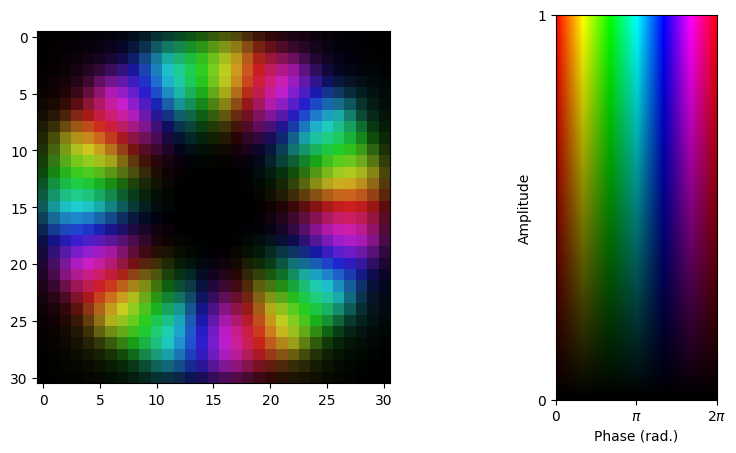

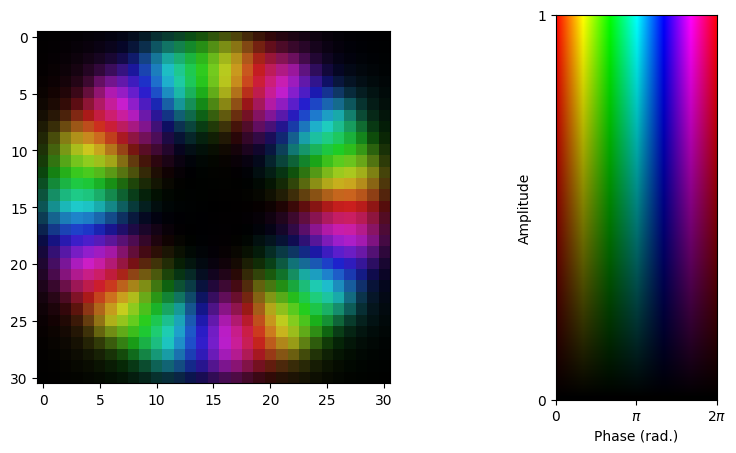

In [48]:
# Make the input and target data using one mode
field_in = PIMs_torch[5]
Field(field_in.cpu()).visualise()

#prop_dist = 0.02
prop_dist = torch.tensor([0.633e-6 / 1.457], dtype=torch.float32).item()
target_field = propagate(field_in, prop_dist)
Field(target_field.cpu()).visualise()

In [10]:
# Run the model with correct parameters to see if it agrees with the target data
model = LengthModel(prop_dist).to(device)
t1 = model(field_in)
# Compute loss
loss = loss_fn(t1, target_field)
loss.item()

0.0

In [50]:
# Try to use n PIMs to make the loss function smoother and wider
n = 1
#prop_dist = 0.02
#prop_dist = (0.633e-6 / 1.457)
prop_dist = torch.tensor([0.633e-6 / 1.457], dtype=torch.float32).item()

fields_in = PIMs_torch[0:n]
#for i in range(n):
#    Field(fields_in[i].cpu()).visualise()

# Target fields 
target_fields = []
for i in range(n):
    field = propagate(fields_in[i], prop_dist)
    target_fields.append(field)

#for i in range(n):
#    Field(target_fields[i].cpu()).visualise()

In [51]:
# Run the model with correct parameters to see if it agrees with the target data
model = LengthModel(prop_dist).to(device)
fields_out = []
for i in range(n):
    field = model(fields_in[i])
    fields_out.append(field)

# Compute loss
loss = loss_func(fields_out, target_fields)
loss.item()

0.0

0
100
200
300
400
500
600
700
800
900


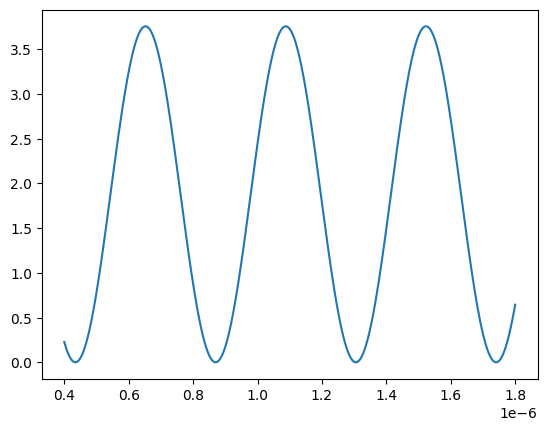

In [52]:
# Plot the loss function for the target data and a spread of fibre distances, showing the disagreement.
loss = []
xs = torch.from_numpy(np.linspace(4e-7,18e-7,1000))

for i in range(xs.size()[0]):
    model = LengthModel(length=xs[i]).to(device)
    fields_out = []

    for j in range(n):
        field = model(fields_in[j])
        fields_out.append(field)

    loss.append(loss_func(fields_out, target_fields).cpu().detach().numpy())

    if i % 100 == 0:
        print(i)

plt.plot(xs,loss)

## Testing 
Not relevant to the main code

In [32]:
test1 = torch.tensor([[1,1,1],[1,1,1]])
test2 = torch.tensor([[2,2,2],[2,2,2]])
test3 = torch.tensor([[3,3,3],[3,3,3]])
test4 = torch.column_stack((test1.flatten(),test2.flatten()))

test5 = torch.column_stack((test4,test3.flatten()))
test5

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [34]:
pim = pim_matrix()
real = real_matrix()

real @ pim

tensor([[ 9.7881e-01+6.3330e-11j,  3.7253e-09+4.4703e-07j,
          5.5879e-08+4.8894e-09j,  ...,
          8.0164e-05+5.5879e-09j, -1.6298e-09-6.9849e-10j,
          9.3132e-09+1.8626e-09j],
        [-4.6566e-09-4.4703e-07j,  9.8473e-01-1.9472e-11j,
         -3.7253e-09-2.9802e-07j,  ...,
          4.6566e-10-5.5879e-09j,  8.0951e-05+0.0000e+00j,
         -4.6566e-10-6.9849e-10j],
        [ 5.5879e-08+9.3132e-10j,  0.0000e+00+2.9802e-07j,
          9.8895e-01+5.9887e-11j,  ...,
         -5.5879e-09-4.6566e-09j, -2.3283e-09-5.5879e-09j,
          8.0164e-05+9.3132e-10j],
        ...,
        [ 8.0157e-05-5.5879e-09j,  4.6566e-10+4.1910e-09j,
         -1.8626e-09+4.6566e-09j,  ...,
          9.8895e-01+5.9887e-11j, -3.7253e-09-2.6822e-07j,
          3.9116e-08+4.8894e-09j],
        [-1.6298e-09+6.5193e-09j,  8.0948e-05+0.0000e+00j,
         -2.3283e-09+4.1910e-09j,  ...,
          0.0000e+00+2.6822e-07j,  9.8473e-01-1.9472e-11j,
          3.7253e-09+4.4703e-07j],
        [ 9.3132e-10-1

In [37]:
test1 = torch.tensor([[1,1,1],[2,2,2],[3,3,3]])
test2 = vectorise(test1)
test3 = unvectorise(test2, 3)
test3

tensor([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]])

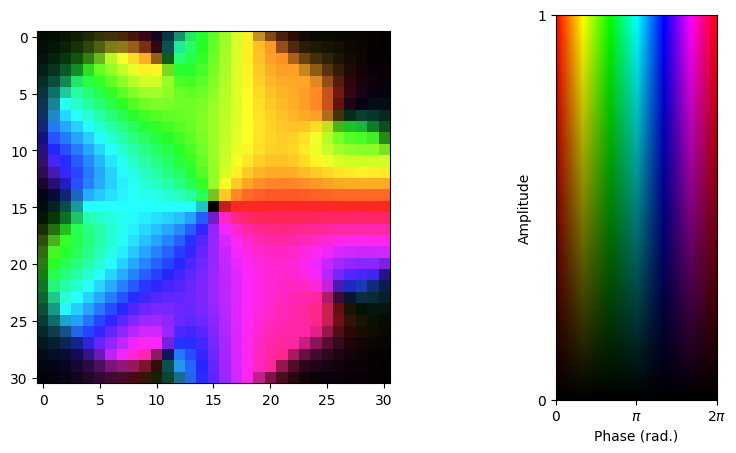

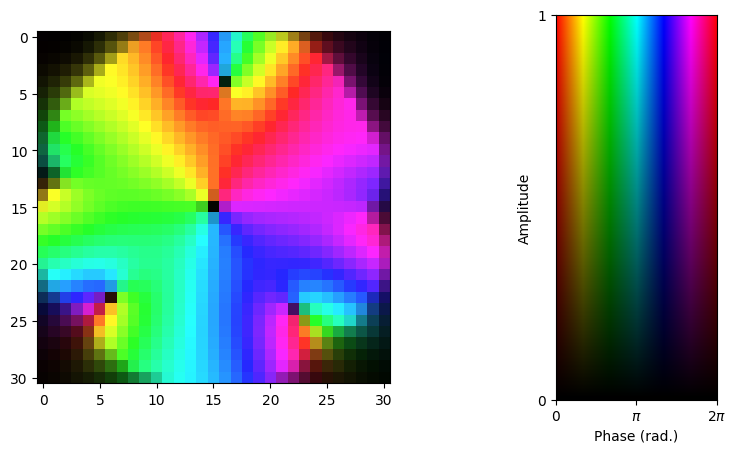

In [55]:
test_field = PIMs_torch[0] + 2 * PIMs_torch[3] + 1.5*PIMs_torch[7] + 5 * PIMs_torch[15]
Field(test_field.cpu()).visualise()

prop_dist = 1
target_test_field = propagate(test_field, prop_dist)
Field(target_test_field.cpu()).visualise()

0
100
200
300
400
500
600
700
800
900


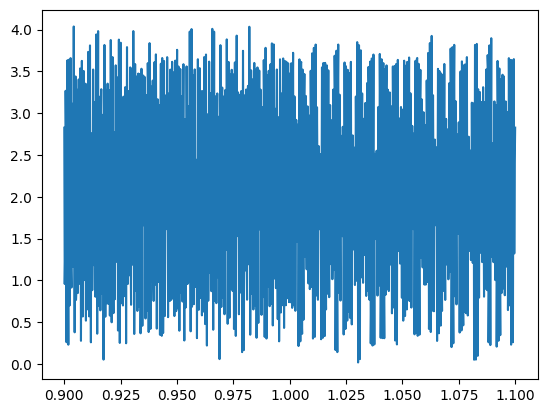

In [56]:
# Plot the loss function for the target data and a spread of fibre distances, showing the disagreement.
n = 1
loss = []
xs = torch.from_numpy(np.linspace(0.9,1.1,1000))

for i in range(xs.size()[0]):
    model = LengthModel(length=xs[i]).to(device)
    fields_out = model(test_field)
    

    loss.append(loss_func(fields_out, target_test_field).cpu().detach().numpy())

    if i % 100 == 0:
        print(i)

plt.plot(xs,loss)

Beta[19] = (14461150+0j)


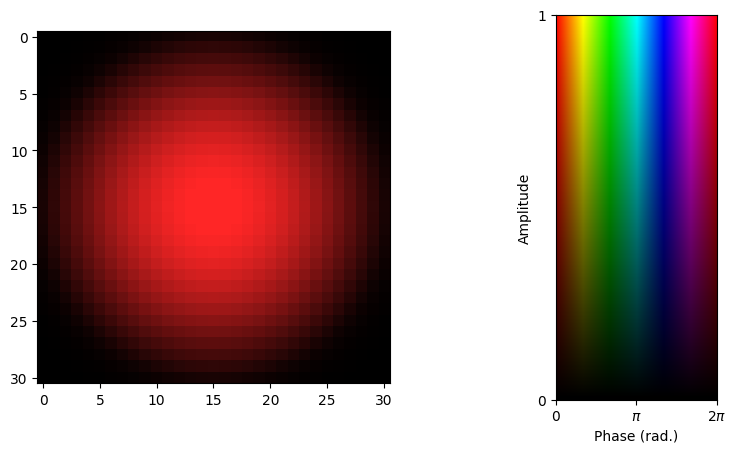

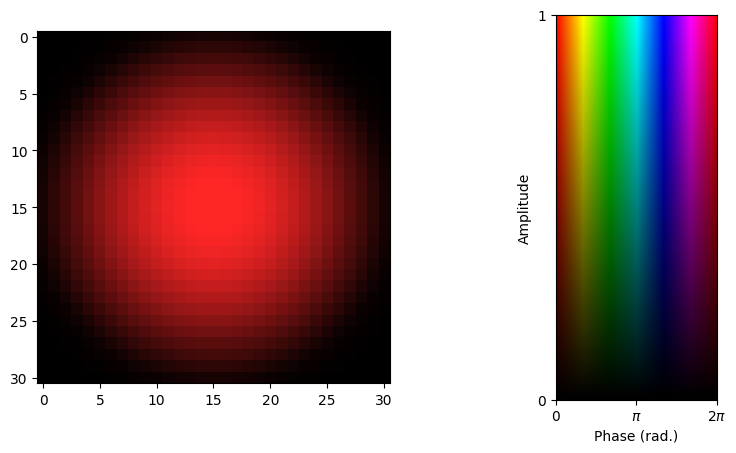

In [60]:
# Make the input and target data using one mode
field_in = PIMs_torch[19]
Field(field_in.cpu()).visualise()
print(f"Beta[19] = {beta_torch[19].item()}")
#prop_dist = 0.02
prop_dist = torch.tensor([0.633e-6 / 1.457], dtype=torch.float32).item()
target_field = propagate(field_in, prop_dist)
Field(target_field.cpu()).visualise()

Beta[20] = (14456496+0j)


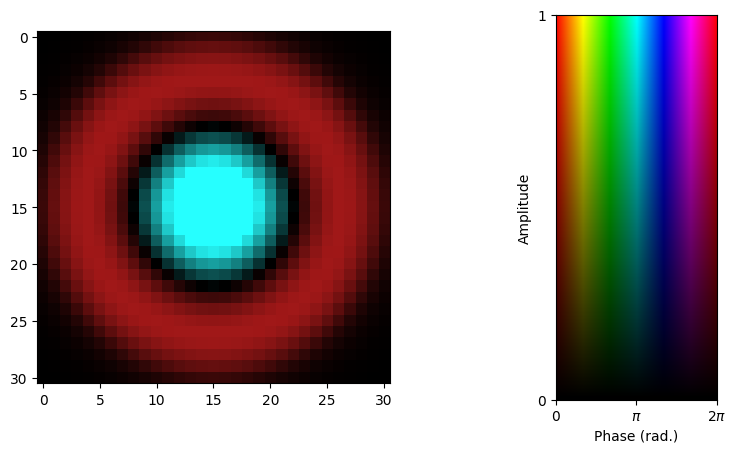

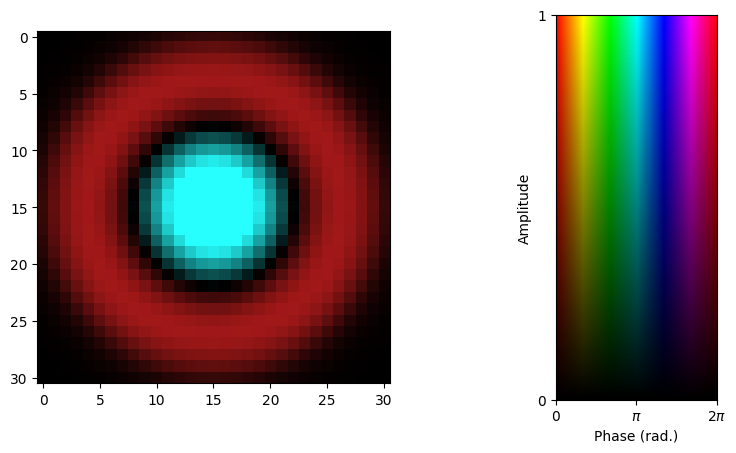

In [61]:
# Make the input and target data using one mode
field_in = PIMs_torch[20]
Field(field_in.cpu()).visualise()
print(f"Beta[20] = {beta_torch[20].item()}")
#prop_dist = 0.02
prop_dist = torch.tensor([0.633e-6 / 1.457], dtype=torch.float32).item()
target_field = propagate(field_in, prop_dist)
Field(target_field.cpu()).visualise()